In [1]:
import sys
import os

In [2]:
import numpy as np
import pandas as pd

In [3]:
pool5 = np.load("../preprocessing/MusiCNNFeatures/pool5.npy")
print(np.shape(pool5))

(400, 40, 128)


In [4]:
print(np.shape(pool5))

(400, 40, 128)


In [5]:
label_songs = pd.read_csv("../preprocessing/labels.csv")
info_songs = pd.read_csv("../data/Info/info.csv")

select_label = "genre"

if select_label == "genre":
    labels = label_songs[select_label].map({"classical":0, "electronic":1, "pop":2, "rock":3})
labels = labels.to_numpy()

In [6]:
n_data = len(label_songs)
idx = np.random.permutation(n_data)
info_songs = info_songs.reindex(idx)
pool5 = pool5[idx, :, :]
labels = labels[idx]

pool5_raw = pool5[:]
labels_raw = labels[:]

In [7]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input, layers
from tensorflow.keras import backend as K

sample_size = (10, 128, 1)

drop_out_rate = 0.5

input_tensor = Input(sample_size)
x = layers.Conv2D(5, (10, 1), padding="valid", activation="relu", strides=1)(input_tensor)
#x = layers.MaxPooling2D(pool_size=(4,1))(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(drop_out_rate)(x)
output_tensor = layers.Dense(4, activation="softmax")(x)

model_1 = tf.keras.Model(input_tensor, output_tensor)
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 128, 5)         55        
_________________________________________________________________
dropout (Dropout)            (None, 1, 128, 5)         0         
_________________________________________________________________
dense (Dense)                (None, 1, 128, 20)        120       
_________________________________________________________________
flatten (Flatten)            (None, 2560)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 10244 

In [8]:
def slice_accordingly(input_tensor, labels, size=10):

    input_shape = (tf.shape(input_tensor).numpy())
    
    input_shape[1] = size
    size = input_shape
    
    sliced_tensor = tf.image.random_crop(input_tensor, size)
    
    nan_values, idx = tf.unique(tf.gather(tf.where(tf.math.is_nan(sliced_tensor)), 0, axis=1))
    nan_values = nan_values.numpy()
  
    msk = np.zeros((input_shape[0]), dtype=np.bool)
    msk[nan_values] = True
    msk = ~msk

    sliced_tensor = tf.boolean_mask(sliced_tensor, msk , axis=0)
    labels = tf.boolean_mask(labels , msk, axis=0)
    
    return sliced_tensor, labels

In [9]:
fraction_validation = 0.25
n_test = int(fraction_validation*len(labels))
n_train = len(labels) - n_test

train_features, train_labels = pool5[:n_train], labels[:n_train]
validation_features, validation_labels = pool5[n_train:], labels[n_train:]

print(n_test)

100


In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_features, validation_labels))

In [11]:
model = model_1

model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

n_epochs = 20
batch_size = 20

history_df = pd.DataFrame()

for epoch in range(n_epochs):
    print("Epoch", epoch)
    train_ds = train_dataset.shuffle(n_train).batch(batch_size)
    val_ds = validation_dataset.shuffle(n_test).batch(n_test)
    
    x_val, y_val = next(iter(val_ds))
    x_val, y_val = slice_accordingly(x_val, y_val)
    
    for X, Y in train_ds:
        X, Y = slice_accordingly(X, Y)
        
        history = model.fit(X, Y,
                           validation_data=(x_val, y_val),
                           verbose=1) 
        
        history = model.fit(X, Y,
                           validation_data=(x_val, y_val),verbose=1)
        history = pd.DataFrame(history.history)
        history_df = history_df.append(history)

Epoch 0
1/1 [==============================] - 0s 67ms/step - loss: 0.9769 - accuracy: 0.7000 - val_loss: 0.8365 - val_accuracy: 0.7000
Epoch 1
1/1 [==============================] - 0s 67ms/step - loss: 0.9248 - accuracy: 0.8000 - val_loss: 0.6061 - val_accuracy: 0.7000
Epoch 2
1/1 [==============================] - 0s 82ms/step - loss: 0.4572 - accuracy: 0.7895 - val_loss: 0.5659 - val_accuracy: 0.7400
Epoch 3
1/1 [==============================] - 0s 66ms/step - loss: 0.3991 - accuracy: 0.8421 - val_loss: 0.6347 - val_accuracy: 0.7200
Epoch 4
1/1 [==============================] - 0s 67ms/step - loss: 0.3819 - accuracy: 0.9000 - val_loss: 0.5237 - val_accuracy: 0.8000
Epoch 5
1/1 [==============================] - 0s 67ms/step - loss: 0.5223 - accuracy: 0.8000 - val_loss: 0.6048 - val_accuracy: 0.7100
Epoch 6
1/1 [==============================] - 0s 65ms/step - loss: 0.5347 - accuracy: 0.7500 - val_loss: 0.6364 - val_accuracy: 0.7100
Epoch 7
1/1 [==============================] - 0

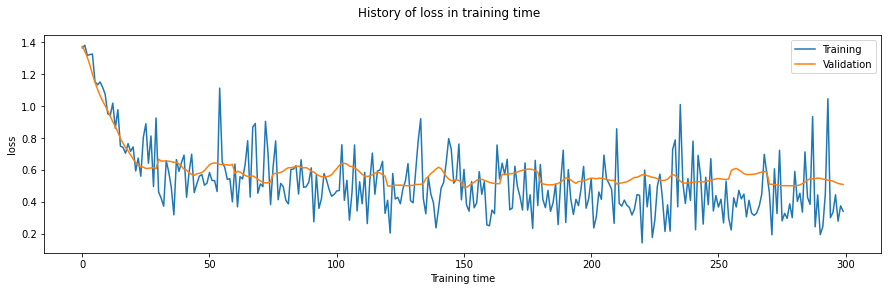

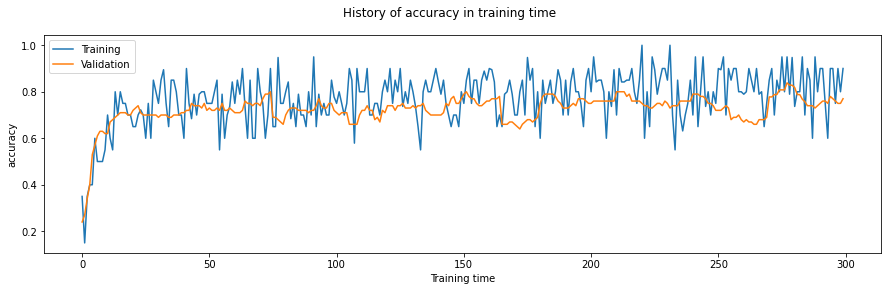

In [12]:
%matplotlib inline

metrics = ["loss", "accuracy"]

metrics_dict = {"loss": ["loss", "val_loss"], "accuracy" : ["accuracy", "val_accuracy"]}

import matplotlib.pyplot as plt
try: history_df = history_df.reset_index()
except: pass

for metric in metrics:
    fig, ax = plt.subplots(figsize=(15,4),nrows=1, ncols=1)
    ax.set_ylabel(f"{metric}")
    ax.set_xlabel("Training time")
    fig.suptitle(f"History of {metric} in training time")

    train_plot = history_df.plot(y=metrics_dict[metric][0], use_index=True, ax=ax, label="Training")
    val_plot = history_df.plot(y=metrics_dict[metric][1], use_index=True, ax=ax, label="Validation")

    plt.show()

# "Cross-validation"

In [13]:
from sklearn.model_selection import KFold


n_splits = 5
kf = KFold(n_splits=n_splits)

predictions_and_labels = {}

count = 0


for train_index, test_index in kf.split(pool5_raw):
    
    print(f"Training K-fold {1+count} of {n_splits}")

    train_features, train_labels = pool5_raw[train_index], labels_raw[train_index]
    validation_features, validation_labels = pool5_raw[test_index], labels_raw[test_index]

    train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
    validation_dataset = tf.data.Dataset.from_tensor_slices((validation_features, validation_labels))
                                        
                                        
    input_tensor = Input(sample_size)
    x = layers.Conv2D(5, (10, 1), padding="valid", activation="relu", strides=1)(input_tensor)
    #x = layers.MaxPooling2D(pool_size=(4,1))(x)
    x = layers.Dropout(drop_out_rate)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(drop_out_rate)(x)
    output_tensor = layers.Dense(4, activation="softmax")(x)

    model = tf.keras.Model(input_tensor, output_tensor)

    model.compile(optimizer="adam",
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
                                        
    n_epochs = 100
    batch_size = 50
    
    for epoch in range(n_epochs):
        train_ds = train_dataset.shuffle(n_train).batch(batch_size)
        for features, labels in train_ds:
            features, labels = slice_accordingly(features, labels)
            model.fit(features, labels, verbose=0)
            
    x_val, y_val = next(iter(val_ds))
    x_val, y_val = slice_accordingly(x_val, y_val)
    
    pred_ = model.predict(x_val)
    
    predictions_and_labels[count] = [pred_, y_val]
    count = count+1

Training K-fold 1 of 5
Training K-fold 2 of 5
Training K-fold 3 of 5
Training K-fold 4 of 5
Training K-fold 5 of 5


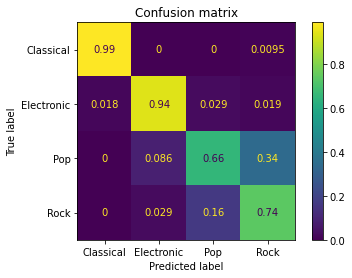

The accuracy is approximately: 0.83 +- 0.02%


In [14]:
%matplotlib inline

import IPython
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = np.zeros((4,4))
accuracies = []

for i in range(max(predictions_and_labels.keys())+1):
    y_pred = predictions_and_labels[i][0]
    y_pred = tf.argmax(y_pred,1)
    y_true = predictions_and_labels[i][1]
    
    conf_mat = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
    
    accuracies.append(np.sum(np.eye(4)*conf_mat)/np.sum(conf_mat))
    
    cm += conf_mat

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = cm / cm.astype(np.float).sum(axis=1)

ls = ["Classical", "Electronic", "Pop", "Rock"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)
disp.plot(include_values=True, colorbar=True, cmap="viridis")
plt.title("Confusion matrix")
plt.show()

print(f'The accuracy is approximately: {np.mean(accuracies):.2f} +- {np.std(accuracies):.2f}%')